In [ ]:
# !pip install datasets opencv-contrib-python opencv-python ipywidgets scipy

## Implementing Bag of Visual Words

### Training Dataset Load and Cleaning

First, we want to import a dataset of images to train the model.

Feel free to use any images you like, but, if you’d like to follow along with the same images, you can download them using HuggingFace Datasets.

In [2]:
from datasets import load_dataset

# download the dataset
data = load_dataset(
    'frgfm/imagenette',
    '160px',
    'verification_mode=no_checks', # set to 'verification_mode=all_checks' if seeing splits Error
    split='train'
)
data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

The chosen dataset is composed of $9469$ images, representing dogs, radios, fishes, cities, and so on. We can visualise some of them below.

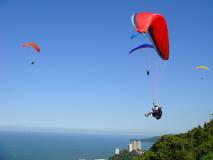

In [3]:
# important to use imagenet[0]['image'] rather than imagenet['image'][0]
# as the latter loads the entire image ctrtvgvrtttttolumn then extracts index 0 (it's slow)
data[3900]['image']

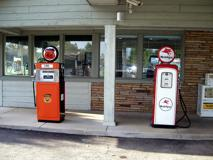

In [4]:
data[5020]['image']

We can now transform these images from PIL objects to numpy arrays.

In [5]:
import numpy as np
from tqdm.notebook import tqdm

# generate an array from the original dataset
images_training = []

for n in tqdm(range(0,len(data))):
    images_training.append(np.array(data[n]['image']))

  0%|          | 0/9469 [00:00<?, ?it/s]

To simplify the model and speed-up the process, we can transform the images from *RGB* to grayscale. This will reduce the image dimension from $3$ to $2$.

To do that, we can use ``cv2``. Note that the dataset might include a mix of RGB and grayscale images. In that case, we would need to trasform only those in RGB, while keeping the grayscale ones as they are. The below code addresses this by looking at the shape's length: if the shape equals $2$, then the image is in grayscale, if the shape is $3$, then the image is RGB.

In [6]:
import cv2

# convert images to grayscale
bw_images = []
for img in tqdm(images_training):
    # if RGB, transform into grayscale
    if len(img.shape) == 3:
        bw_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    else:
        # if grayscale, do not transform
        bw_images.append(img)

  0%|          | 0/9469 [00:00<?, ?it/s]

Let's take a look at a transformed image.

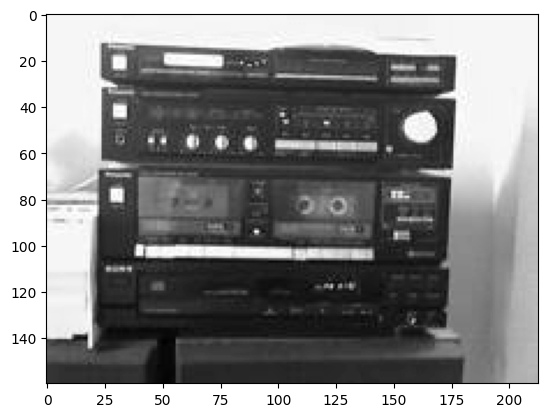

In [7]:
import matplotlib.pyplot as plt

plt.imshow(bw_images[1], cmap='gray')
plt.show()

We have now a dataset of images that we can use to train our model. Let's see how to build it.

### Visual features Extraction

The first step is to extract the image visual features (keypoints and descriptors). As previously mentioned, we will use SIFT, a feature detector.

In [8]:
# defining feature extractor that we want to use (SIFT)
extractor = cv2.xfeatures2d.SIFT_create()

# initialize lists where we will store *all* keypoints and descriptors
keypoints = []
descriptors = []

for img in tqdm(bw_images):
    # extract keypoints and descriptors for each image
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

  0%|          | 0/9469 [00:00<?, ?it/s]

Some images might return `None` when attempting to extract keypoints using SIFT. This is (usually) because the SIFT algorithm cannot detect any keypoints (common when an image is very flat without obvious edges). In that case, we remove those images from our data.

In [9]:
print(f"len before: {len(descriptors)}")
# initialize list to store idx values of records to drop
to_drop = []
for i, img_descriptors in enumerate(descriptors):
    # if there are no descriptors, add record idx to drop list
    if img_descriptors is None:
        to_drop.append(i)

print(f"indexes: {to_drop}")
# delete from list in reverse order
for i in sorted(to_drop, reverse=True):
    del descriptors[i], keypoints[i]

print(f"len after: {len(descriptors)}")

len before: 9469
indexes: [3775, 4286, 4291]
len after: 9466


For this sample, we fortunately don't have this issue - as we can see the before/after length has not changed.

Now that we have extracted the features, we can visualize them on some images.

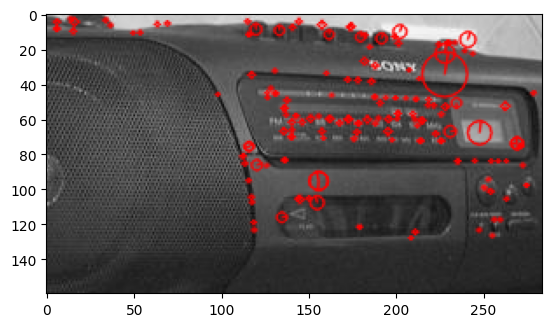

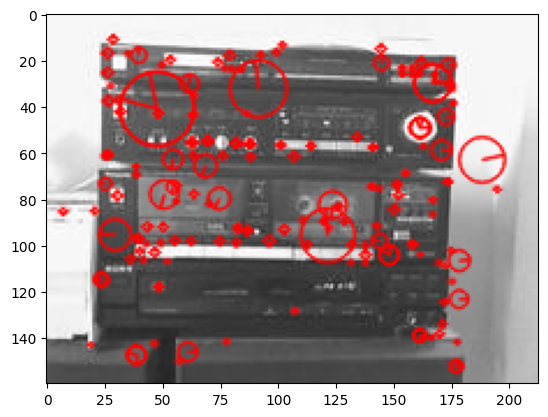

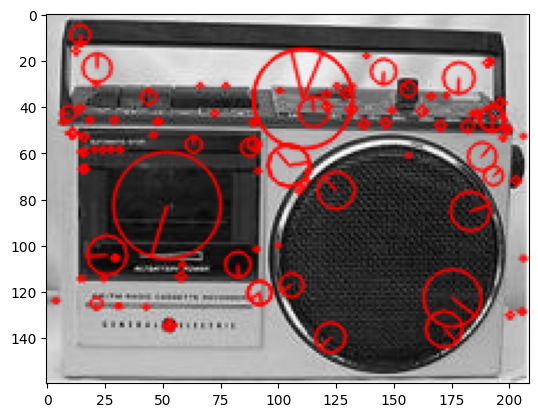

In [10]:
output_image = []
for x in range(3):
    output_image.append(cv2.drawKeypoints(bw_images[x], keypoints[x], 0, (255, 0, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x], cmap='gray')
    plt.show()

The centre of each circle is the keypoint location, the line from the centre to the circle is the orientation of the keypoint, and the size of the circle is the scale at which this feature was detected.

We are now ready to build the codebook!

### Building the Codebook

To build the codebook, we will randomly sample $1000$ of the image descriptors. To create the sample we use Numpy to generate $1000$ random integer numbers from $0$ to $9469$ (the length of the dataset). We set `np.random.seed(0)` to generate the same sample for reproducability.

In [11]:
import numpy as np

# select the same numbers in each run
np.random.seed(0)
# select 1000 random image index values
sample_idx = np.random.randint(0, len(data)+1, 1000).tolist()
len(sample_idx)

1000

First, we want to stack the generated descriptors into a numpy array. This will be a single array of *all* the chosen descriptors across *all* the corresponding images. To be more precise, we are going to extract the corresponding keypoints, even though we are not going to use them going ahead.

In [12]:
# extract the sample from descriptors
# (we don't need keypoints)
descriptors_sample = []

for n in tqdm(sample_idx):
    descriptors_sample.append(np.array(descriptors[n]))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
all_descriptors = []
# extract image descriptor lists
for img_descriptors in tqdm(descriptors_sample):
    # extract specific descriptors within the image
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)
# convert to single numpy array
all_descriptors = np.stack(all_descriptors)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
# check the shape
all_descriptors.shape

(274113, 128)

We now have *all* descriptors (each descriptor being a 128-dimensional vector) across *all* sampled images. There are around *1,130,000* of these in total.

In [15]:
# we can count the number of descriptors contained in descriptors to confirm
count = []
for img_descriptors in descriptors_sample:
    count.append(len(img_descriptors))
# here we can see the number of descriptors for the first five images
print(f"first five: {count[:5]}")
# and if we sum them all, we should see the 39893 from before
print(f"count all: {sum(count)}")

first five: [451, 372, 227, 255, 400]
count all: 274113


We now want to group similar visual features (descriptors) using *k-means*. After a few tests, we chose $k=200$ for our model.

After k-means, all images will be reduced to *visual words* and we will use that to build our codebook.

*It can be difficult to find the optimal size of our codebook - if too small, visual words could be not representative of all image regions, if too large, there could be too many visual words with little-no of them being shared between images (making comparisons very hard or impossible).*

Once built, the codebook won't change anymore, i.e., will stay fixed!

In [16]:
# perform k-means clustering to build the codebook
from scipy.cluster.vq import kmeans

k = 200
iters = 1
codebook, variance = kmeans(all_descriptors, k, iters) # It takes approx. 2-3 minutes

### Saving Codebook

We save the codebook and key parameters like `k` into a file so that in the future we just load these when processing new images.

In [17]:
import joblib

# save number of clusters and codebook
# Joblib dumps Python object into one file
joblib.dump((k, codebook), "bovw-codebook.pkl", compress=3)

['bovw-codebook.pkl']

To *emulate* this approach, we can go ahead and load `k` and our `codebook` from file to use for the rest of the notebook - this is optional and not necessary, feel free to not run the next code cell.

In [18]:
# load the visual features, number of clusters, and codebook
k, codebook = joblib.load("bovw-codebook.pkl")

### Building Sparse Vectors

After building our `codebook` we can begin building the sparse vector representations of our images, this requires three steps, (1) vector quantization, (2) frequency count, and (3) tf-idf.

#### 1. Vector quantization:

Transforming the visual *feature* representations of our images into *visual words*.

In [19]:
# vector quantization
from scipy.cluster.vq import vq

visual_words = []
for img_descriptors in tqdm(descriptors):
    # for each image, map each descriptor to the nearest codebook entry
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

  0%|          | 0/9466 [00:00<?, ?it/s]

In [20]:
# let's see what the visual words look like for image 0
visual_words[0][:5], len(visual_words[0])

(array([129, 139,  75,  19, 147], dtype=int32), 167)

*each of these values, `84`, `22`, etc., represent a centroid (visual word) from the codebook:*

In [21]:
# the centroid that represents visual word 84 is of dimensionality...
codebook[84].shape  # (all have the same dimensionality)

(128,)

#### 2. Frequency count

For each visual word found in the codebook, how often does it appear in an image? We format this as a sparse vector with frequency counts. We select the position to place a count for a visual word using the visual word identifier, e.g., position `84` for the visual word we showed above.

In [22]:
frequency_vectors = []
for img_visual_words in tqdm(visual_words):
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

  0%|          | 0/9466 [00:00<?, ?it/s]

In [23]:
frequency_vectors.shape

(9466, 200)

*we know from above that positions `[84,  22,  45, 172]` should all count at least `1` (and at least `2` for position `172`) in the frequency vector for image 0:*

In [24]:
# we know from above that ids 84, 22, 45, and 172 appear in image 0
for i in [84,  22,  45, 172]:
    print(f"{i}: {frequency_vectors[0][i]}")

84: 2.0
22: 0.0
45: 0.0
172: 0.0


*let's see some more of image 0's frequency vector...*

In [25]:
frequency_vectors[0][:20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 2.,
       1., 2., 1.])

*we can also visualize the full image in a histogram like so:*

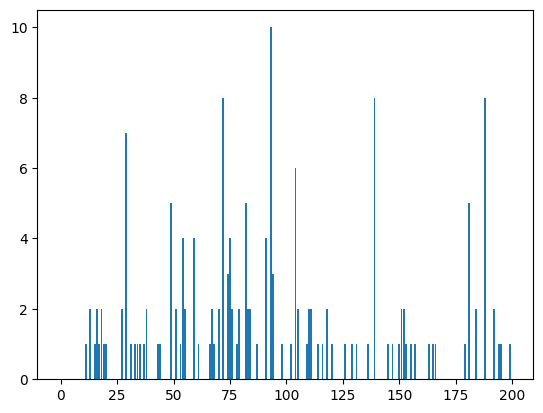

In [26]:
plt.bar(list(range(k)), frequency_vectors[0])
plt.show()

#### 3. Tf-idf

The above histogram does not consider the relevance of the visual words. That is why, we want to re-weight them using tf-idf.

For reference, here is the formula. Try and refer to this if any of the following code is hard to understand.

$$tf\textrm{--}idf_{t,d} = tf_{t,d} * idf_t = tf_{t,d} * log\frac{N}{df_t}$$

where:

* $tf_{t,d}$ is the term frequency of the visual word $t$ in the image $d$ (the number of times $t$ occurs in $d$).
* $N$ is the total number of images.
* $df_t$ number of images containing visual word $t$.
* $log\frac{N}{df_t}$ measures the how common visual word $t$ is across all images in the database. This is low if the visual word $d$ occurs many times in the image, high otherwise.

Let's first calculate "*df*", given $N = 9469$, i.e., the length of our dataset.

In [27]:
# N is the number of images, i.e. the size of the dataset
N = 9469

# df is the number of images that a visual word appears in
# we calculate it by counting non-zero values as 1 and summing
df = np.sum(frequency_vectors > 0, axis=0)

In [28]:
df.shape, df[:5]

((200,), array([5193, 6036, 5743, 5932, 6332]))

*from this we know that visual word `0` appears in `7935` images, visual word `1` in `7373` images, and so on.*

Using `N` and `df` we can calculate *"idf"* (which is the same for every image).

In [29]:
idf = np.log(N/ df)
idf.shape, idf[:5]

((200,), array([0.60071174, 0.45028176, 0.50004158, 0.46766188, 0.40240716]))

Now we move on to the full tf-idf calculation, we just multiply the *"tf"* for each image by this `idf` vector. We have already calculated the *"tf"* values, they are the frequency vectors stored in `frequency_vectors`.

In [30]:
tfidf = frequency_vectors * idf
tfidf.shape, tfidf[0][:5]

((9466, 200), array([0., 0., 0., 0., 0.]))

Visualizing the tf-idf vector for image `0` gives use:

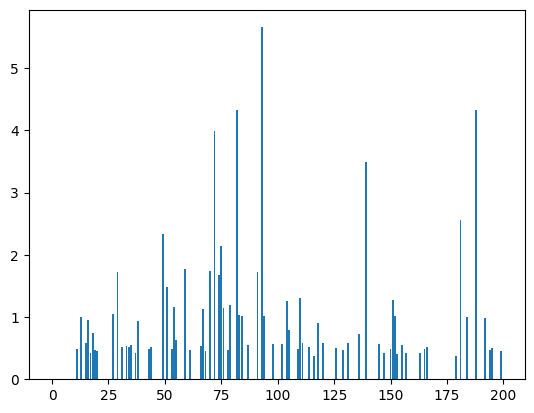

In [31]:
plt.bar(list(range(k)), tfidf[0])
plt.show()

### Finalizing Results

We have now generated tf-idf vectors based on the visual words of our images. To compare these images we can use a metric like *cosine similarity*.

We will use image `6` as our search term:

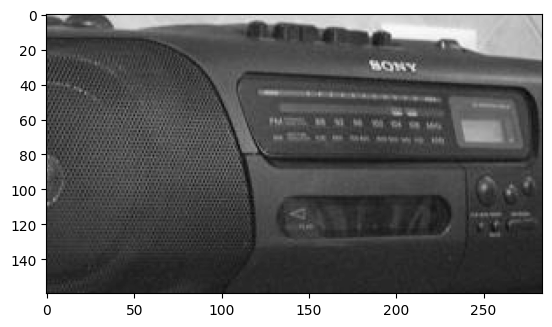

In [69]:
search_i = 0

plt.imshow(bw_images[search_i], cmap='gray')
plt.show()

Again, for reference, our cosine similarity range is $[0,1]$, and it is calculated as follows:

$$cossim(A,B)= cos(\theta)=\frac{A \cdot B}{||A|| \space ||B||}$$

In [70]:
# cosine similarity
from numpy.linalg import norm

a = tfidf[search_i]
b = tfidf  # set search space to the full sample

cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
print("Min cosine similarity:", round(np.min(cosine_similarity),1))
print("Max cosine similarity:", np.max(cosine_similarity))

Min cosine similarity: 0.0
Max cosine similarity: 1.0


In our TF-IDF vectors, two highly similar images should be separated by a very small angular distance. Using cosine similarity, small angles output a high score (i.e., towards $1$).

Let's pick a random image from our dataset and retrieve the top 5 most similar images.

In [71]:
cosine_similarity.shape

(9466,)

In [72]:
cosine_similarity

array([1.        , 0.45337217, 0.46996767, ..., 0.36674746, 0.49757082,
       0.53180252])

To find the `top_k` most similar items, we use Numpy's `argpartition`.

In [73]:
top_k = 5
idx = np.argsort(-cosine_similarity)[:top_k]
idx

array([   0,  924,  780, 2732, 2627])

The first image in the array should correspond to the image itself. Therefore, the cosine similarity must be $≅1$.

In [74]:
cosine_similarity[idx[0]]

1.0

0: 1.0


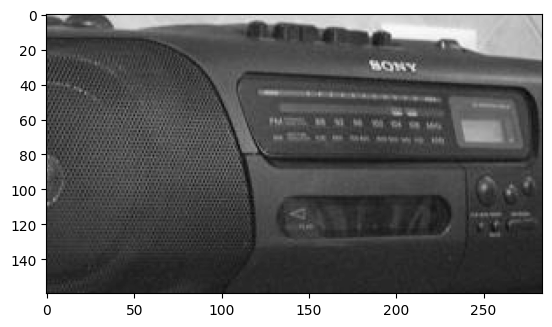

924: 0.6763


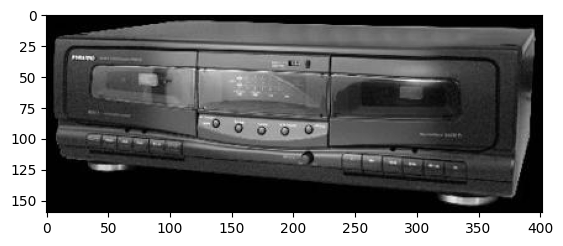

780: 0.6754


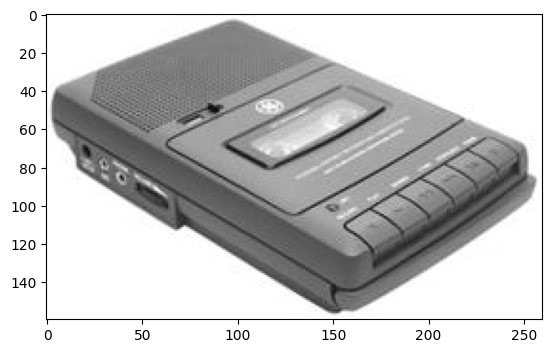

2732: 0.6743


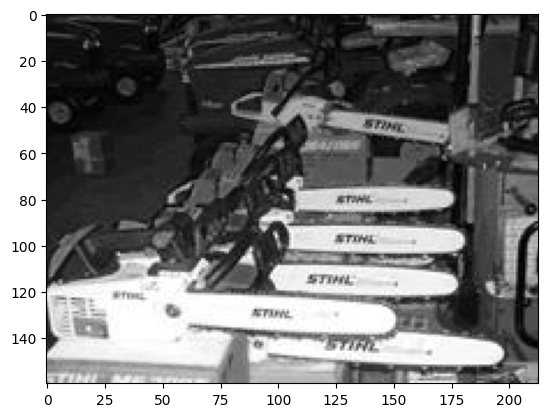

2627: 0.6736


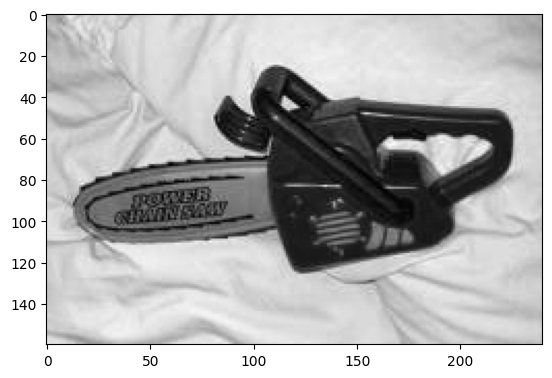

In [75]:
for i in idx:
    print(f"{i}: {round(cosine_similarity[i], 4)}")
    plt.imshow(bw_images[i], cmap='gray')
    plt.show()

This looks promising, we can test with a few more images.

In [39]:
def search(i: int, top_k: int = 5):
    print("Search image:")
    # show the search image
    plt.imshow(bw_images[i], cmap='gray')
    plt.show()
    print("-----------------------------------------------------")
    # get search image vector
    a = tfidf[i]
    # get the cosine distance for the search image `a`
    cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
    # get the top k indices for most similar vecs
    idx = np.argsort(-cosine_similarity)[:top_k]
    # display the results
    for i in idx:
        print(f"{i}: {round(cosine_similarity[i], 4)}")
        plt.imshow(bw_images[i], cmap='gray')
        plt.show()

Search image:


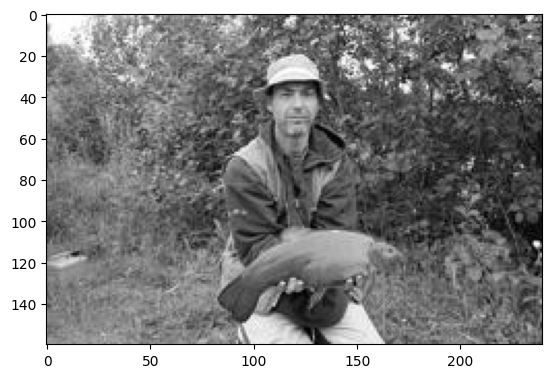

-----------------------------------------------------
1200: 1.0


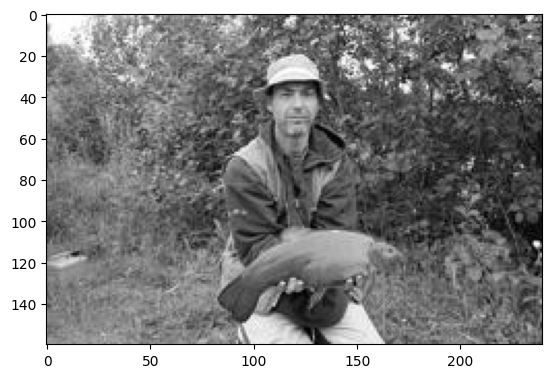

6846: 0.8038


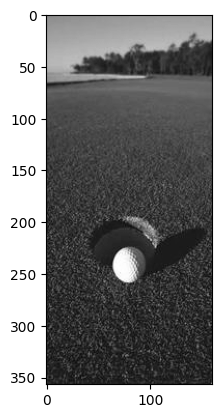

1609: 0.7948


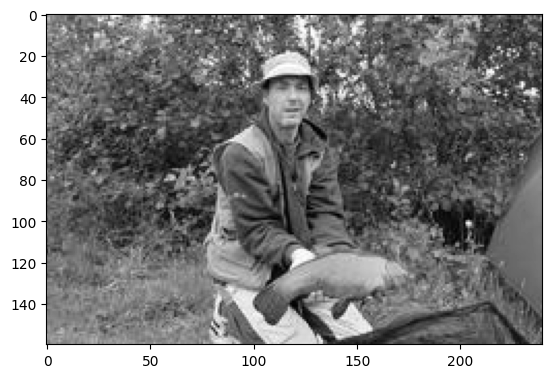

7350: 0.7938


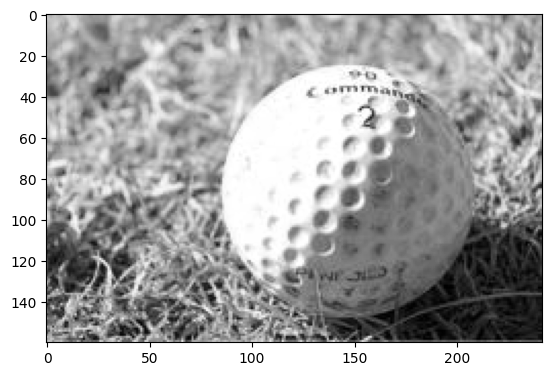

6219: 0.7917


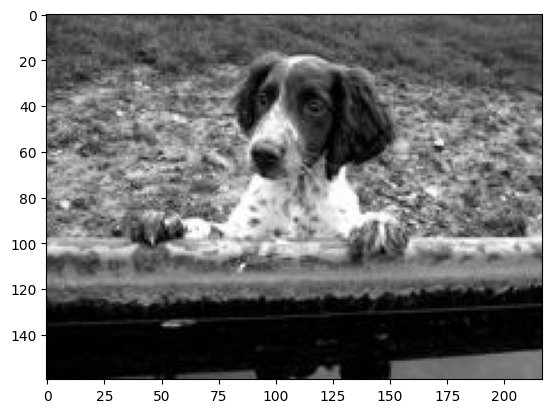

In [40]:
search(1200)

Search image:


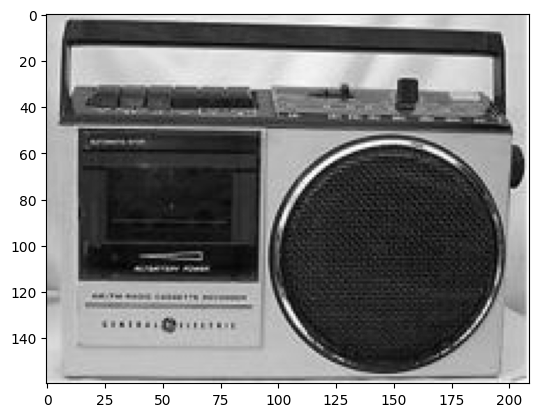

-----------------------------------------------------
2: 1.0


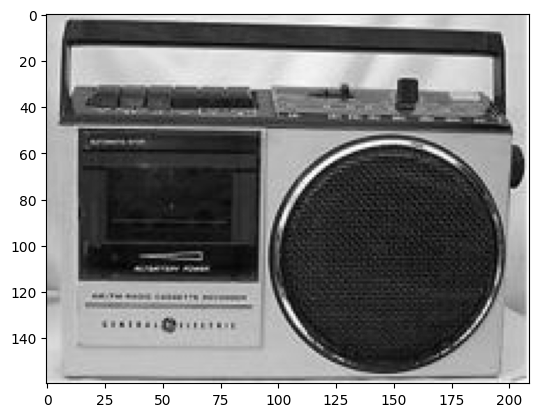

266: 0.789


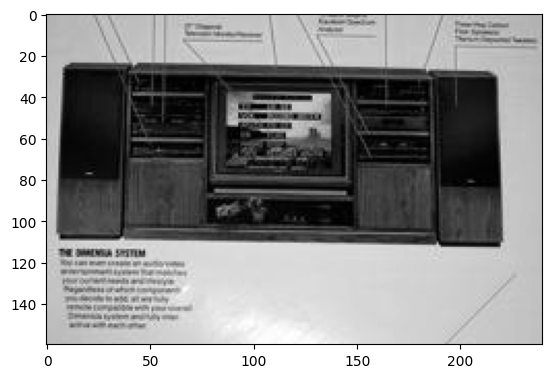

62: 0.7474


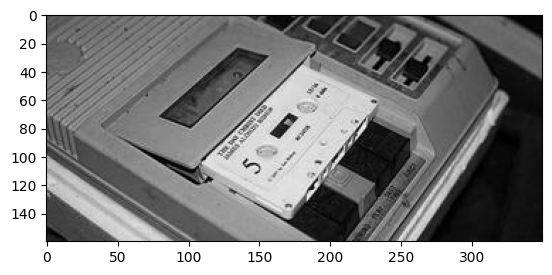

693: 0.7318


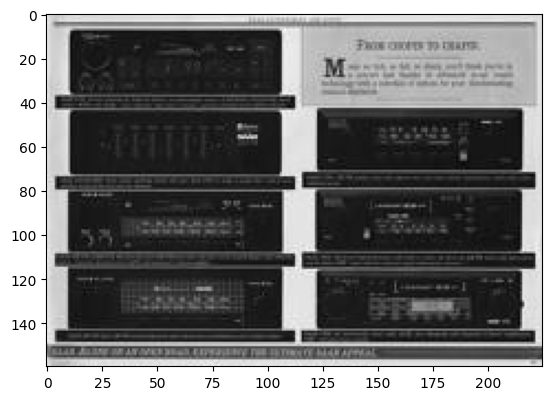

9284: 0.7303


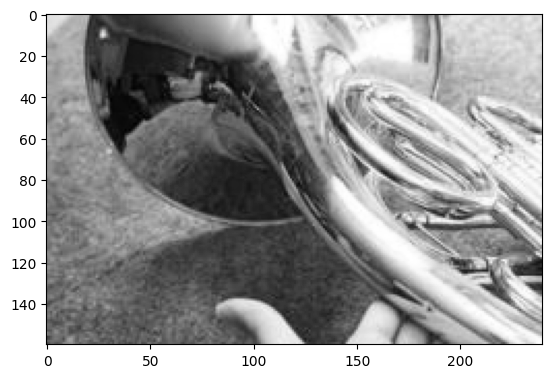

In [41]:
search(2)

Search image:


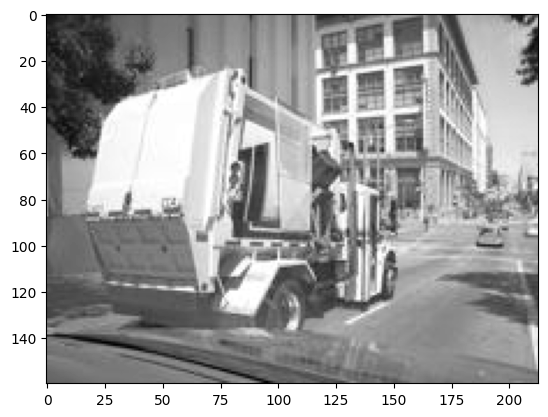

-----------------------------------------------------
8450: 1.0


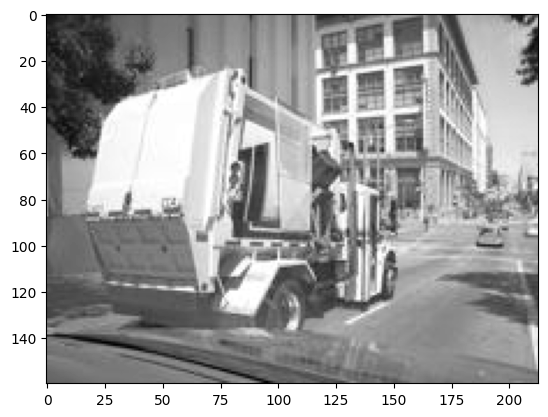

2055: 0.6945


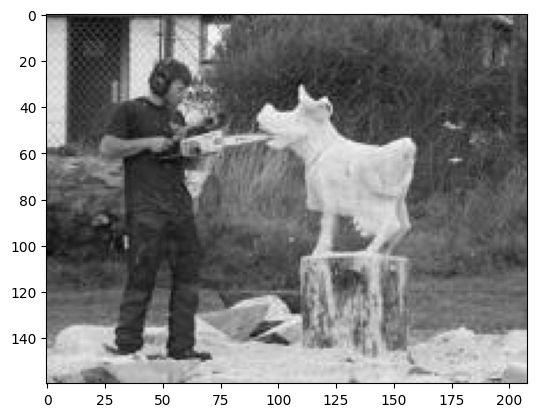

7694: 0.6839


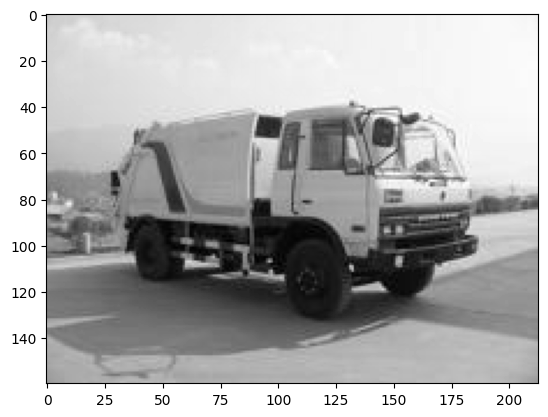

2167: 0.6794


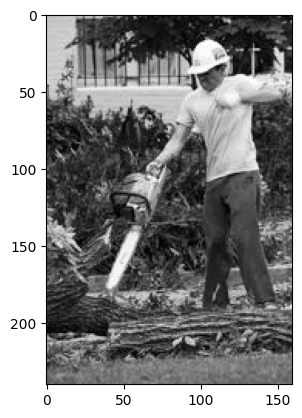

8492: 0.6786


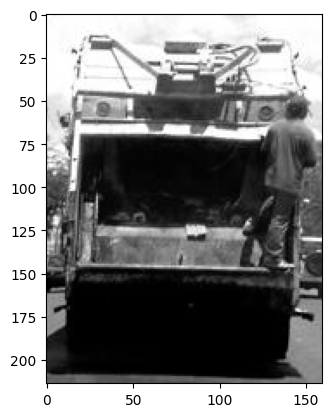

In [42]:
search(8450)

The results are not always perfect, but for the most part it seems to manage in returning similar images.

---